In [1]:
from dslab_virgo_tsi.data_utils import load_data
from dslab_virgo_tsi.constants import Constants as Const
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data = load_data(Const.DATA_DIR, Const.VIRGO_FILE)
data = data.dropna()
data

,TIME,PMO6V-A,PMO6V-B,TEMPERATURE
17635,83.2468,1365.584,1365.092,22.037
17636,83.2475,1365.552,1365.062,22.037
17637,83.2481,1365.529,1365.024,22.037
17638,83.2488,1365.552,1365.028,22.037
17639,83.2495,1365.576,1365.021,22.037
...,...,...,...,...
12327583,8631.8213,1358.447,1364.856,26.567
12327584,8631.8223,1358.483,1364.822,26.565
12327594,8631.8291,1358.305,1364.682,26.519
12327595,8631.8301,1358.394,1364.704,26.530


In [3]:
temp = data["TEMPERATURE"]
size = temp.shape[0]

Text(0, 0.5, 'temperature')

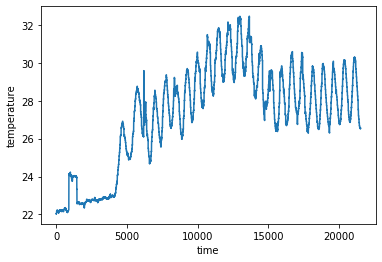

In [4]:
ind = np.arange(size)
plt.plot(ind, temp)
plt.xlabel("time")
plt.ylabel("temperature")

In [5]:
b = data["PMO6V-B"]
a = data["PMO6V-A"]

In [6]:
def get_opt_params(temp, signal, weight):
    # Currently minimal score
    min_score = None
    best_hm = None
    best_mean_temp = None

    # Temperatures tested - value here is a temperature at which measurement is not affected by heat
    mean_temps = np.array(list(range(0, 32 * 5, 1))) / 5
    # Temperature scaling values
    how_much = np.array(list(range(1, 1 * 50))) / 50
    for hm in how_much:
        for mean_temp in mean_temps:
            corrected_values = signal - hm * (temp - mean_temp)

            # Difference between 2 consecutive measurements
            diffs = corrected_values[:-1].ravel() - corrected_values[1:].ravel()

            # Smoothness estimate
            # https://stats.stackexchange.com/questions/24607/how-to-measure-smoothness-of-a-time-series-in-r
            smooth = np.std(diffs)/np.abs(np.mean(diffs))

            # Similarity between temperature corrected and original values
            similarity = np.sum(np.abs(signal - corrected_values)) / signal.shape[0]

            # Score optimizes for smoothness and similiarity
            score = 1 * smooth + weight * similarity
            if min_score is None or score < min_score:
                min_score = score
                best_hm = hm
                best_mean_temp = mean_temp
                print(f"{hm}, {mean_temp}: {score}")
        
    return best_hm, best_mean_temp

0.02, 0.0: 16210.109969745161
0.02, 0.2: 16130.109969745161
0.02, 0.4: 16050.109969745141
0.02, 0.6: 15970.109969745166
0.02, 0.8: 15890.109969745146
0.02, 1.0: 15810.109969745117
0.02, 1.2: 15730.109969742618
0.02, 1.4: 15650.10996974516
0.02, 1.6: 15570.109969745168
0.02, 1.8: 15490.109969745132
0.02, 2.0: 15410.109969745141
0.02, 2.2: 15330.109969742582
0.02, 2.4: 15250.109969745161
0.02, 2.6: 15170.109969745157
0.02, 2.8: 15090.109969745126
0.02, 3.0: 15010.109969745168
0.02, 3.2: 14930.10996974514
0.02, 3.4: 14850.109969745146
0.02, 3.6: 14770.109969742618
0.02, 3.8: 14690.10996974515
0.02, 4.0: 14610.109969745161
0.02, 4.2: 14530.109969745114
0.02, 4.4: 14450.109969745135
0.02, 4.6: 14370.109969742585
0.02, 4.8: 14290.109969745148
0.02, 5.0: 14210.109969745157
0.02, 5.2: 14130.109969745141
0.02, 5.4: 14050.109969745183
0.02, 5.6: 13970.109969745117
0.02, 5.8: 13890.109969745146
0.02, 6.0: 13810.109969742602
0.02, 6.2: 13730.109969745165
0.02, 6.4: 13650.109969745135
0.02, 6.6: 13

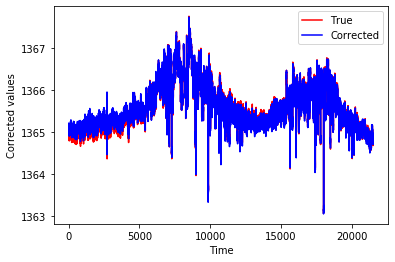

In [7]:
# Run
hm, mean_temp = get_opt_params(temp, b, 20000)

# Plot of best result
plt.plot(ind, b, 'r', label="True")
plt.plot(ind, b - hm * (temp - mean_temp), 'b', label="Corrected")
plt.xlabel("Time")
plt.ylabel("Corrected values")
plt.legend()

In [8]:
import pickle
with open("/home/luka/Development/dslab_virgo_tsi/results/2019-11-04_12-20-59_smooth_monotonic/smooth_monotonic_modeling_result.pkl", "rb") as f:
    res = pickle.load(f)
from scipy.interpolate import interp1d

In [9]:
interp_fun = interp1d(res.base_signals.t_mutual_nn, temp, kind="nearest")
min_time = np.maximum(np.ceil(res.base_signals.t_a_nn.min()), np.ceil(res.base_signals.t_b_nn.min()))
max_time = np.minimum(np.floor(res.base_signals.t_a_nn.max()), np.floor(res.base_signals.t_b_nn.max()))

num_days = int((max_time - min_time) + 1)
num_hours = int(24 * (max_time - min_time) + 1)

t_hourly_out = np.linspace(min_time, max_time, num_hours)
t_daily_out = np.linspace(min_time, max_time, num_days)

In [10]:
temp_out = interp_fun(t_hourly_out)
time_out = res.out.t_hourly_out
signal_out = res.out.signal_hourly_out

print(temp_out.shape)
print(signal_out.shape)

(205129,)
(205129,)


0.02, 0.0: 36411.68312828742
0.02, 0.2: 36331.683128326404
0.02, 0.4: 36251.68312828742
0.02, 0.6: 36171.683128326375
0.02, 0.8: 36091.68312832643
0.02, 1.0: 36011.68312832627
0.02, 1.2: 35931.68312832659
0.02, 1.4: 35851.68312828739
0.02, 1.6: 35771.68312832645
0.02, 1.8: 35691.68312832647
0.02, 2.0: 35611.68312832644
0.02, 2.2: 35531.68312832645
0.02, 2.4: 35451.68312828747
0.02, 2.6: 35371.68312832638
0.02, 2.8: 35291.68312828743
0.02, 3.0: 35211.683128326375
0.02, 3.2: 35131.683128326404
0.02, 3.4: 35051.68312832622
0.02, 3.6: 34971.683128326564
0.02, 3.8: 34891.683128287375
0.02, 4.0: 34811.683128326455
0.02, 4.2: 34731.68312832644
0.02, 4.4: 34651.68312832633
0.02, 4.6: 34571.68312832648
0.02, 4.8: 34491.6831282875
0.02, 5.0: 34411.683128326404
0.02, 5.2: 34331.683128287434
0.02, 5.4: 34251.68312832641
0.02, 5.6: 34171.683128326375
0.02, 5.8: 34091.683128326215
0.02, 6.0: 34011.68312832651
0.02, 6.2: 33931.68312828745
0.02, 6.4: 33851.683128326375
0.02, 6.6: 33771.68312832643
0.0

/home/luka/.conda/envs/flaskbackendenv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/luka/.conda/envs/flaskbackendenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


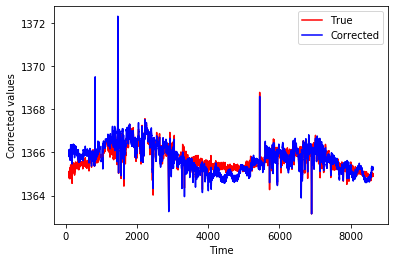

In [11]:
# Run
hm, mean_temp = get_opt_params(temp_out, signal_out, 20000)

# Plot of best result
plt.plot(time_out, signal_out, 'r', label="True")
plt.plot(time_out, signal_out - hm * (temp_out - mean_temp), 'b', label="Corrected")
plt.xlabel("Time")
plt.ylabel("Corrected values")
plt.legend()